In [1]:
import torch
import math
import matplotlib.pyplot as plt
from diffusers import FluxPipeline

/root/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
DTYPE = torch.bfloat16

pipe = FluxPipeline.from_pretrained("/root/autodl-tmp/FLUX-dev", torch_dtype=DTYPE)
pipe.to("cuda")
# pipe.enable_model_cpu_offload() 

# pipe.load_lora_weights("/root/autodl-tmp/data/Flux_Aquarell_Watercolor_v2.safetensors")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.31.0.dev0",
  "_name_or_path": "/root/autodl-tmp/FLUX-dev",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Token indices sequence length is longer than the specified maximum sequence length for this model (115 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', there are subtle, glowing lines and digital glitch effects, creating a sense of urgency and importance. the overall style is modern and eye - catching, perfect for grabbing attention on social media.']


  0%|          | 0/50 [00:00<?, ?it/s]

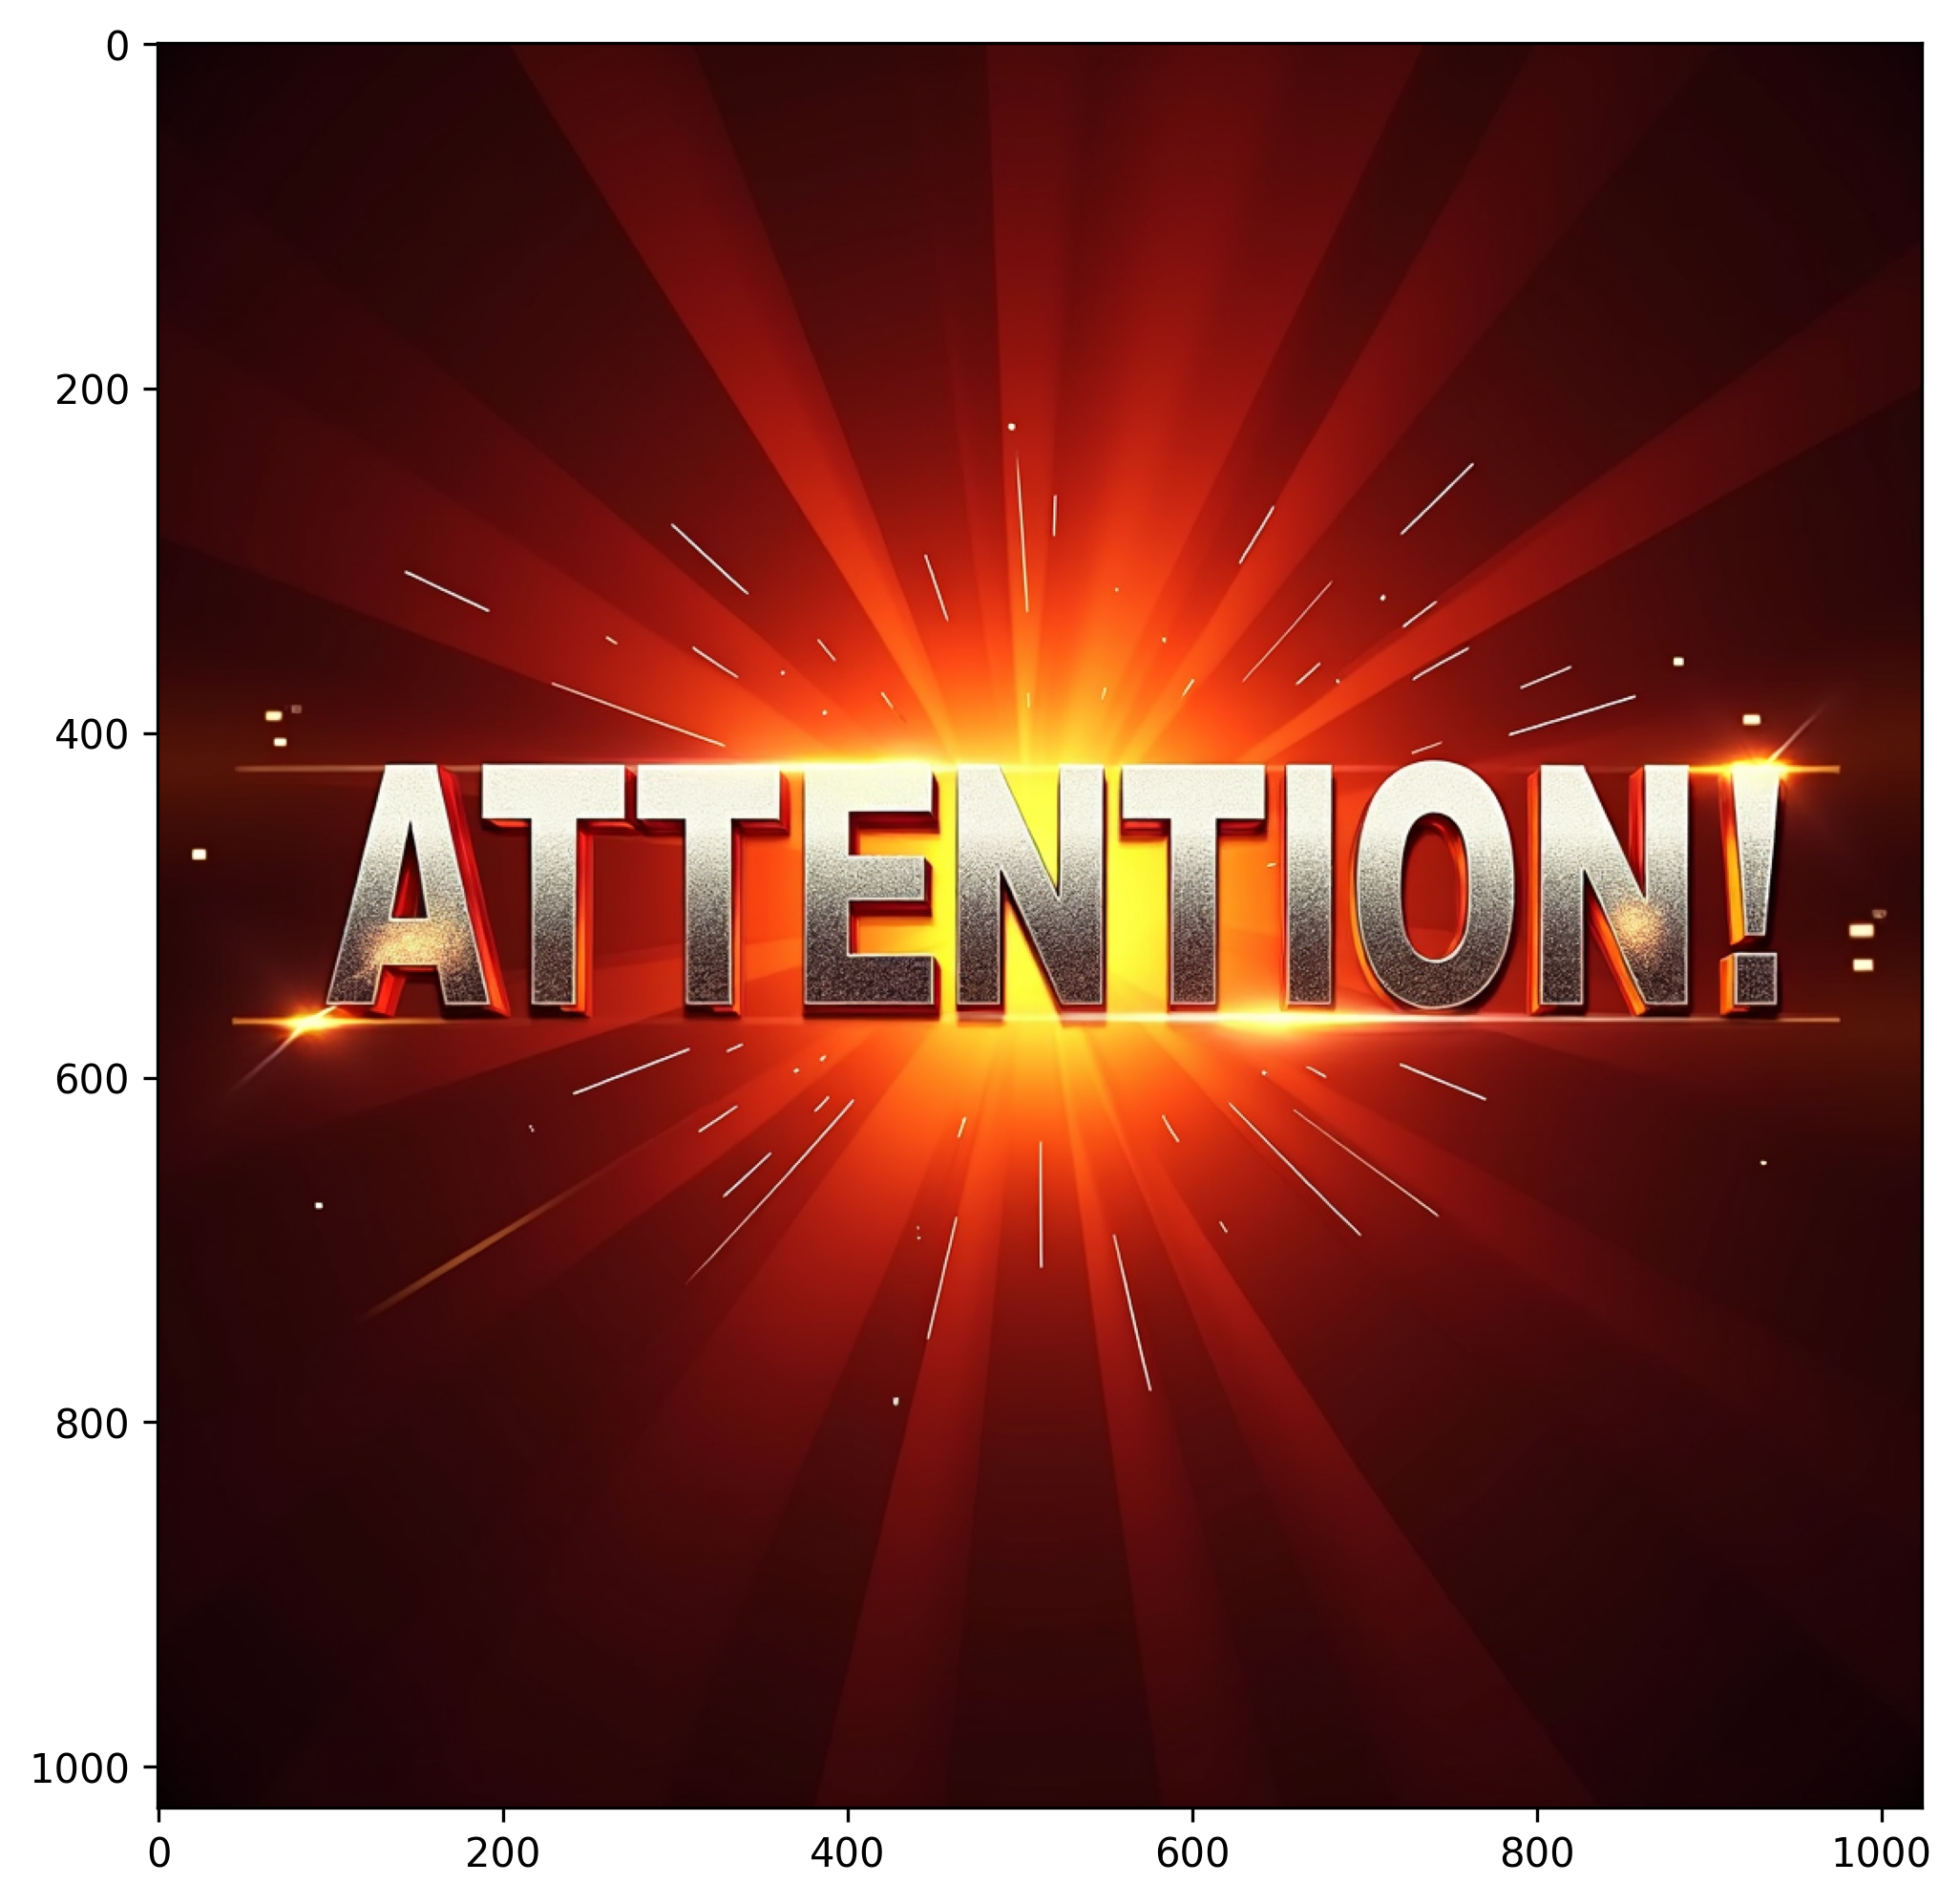

In [3]:
from matplotlib import pyplot as plt

prompt = "A high-impact Telegram post with the text 'ATTENTION!': the background is a vibrant and intense gradient of red and orange, with a subtle radial burst effect emanating from the center. The word 'ATTENTION!' is placed prominently in the center in a bold, sans-serif font with a metallic finish, slightly tilted for added dynamism. Surrounding the text, there are subtle, glowing lines and digital glitch effects, creating a sense of urgency and importance. The overall style is modern and eye-catching, perfect for grabbing attention on social media."

out = pipe(
    prompt=prompt,
    guidance_scale=3.5,
    height=1024,
    width=1024,
    num_inference_steps=50,
	generator=torch.Generator(device='cuda').manual_seed(0)
).images[0]

plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(out)

In [4]:
from diffusers import (
    AutoencoderKL,
    FlowMatchEulerDiscreteScheduler,
    FluxPipeline,
    FluxTransformer2DModel,
)
from transformers import CLIPTokenizer, PretrainedConfig, T5TokenizerFast, CLIPTextModel, T5EncoderModel
from reflow.flux_utils import encode_imgs, decode_imgs, get_noise, get_schedule

def get_models(pretrained_model_name_or_path):
    scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="scheduler",
        torch_dtype=torch.bfloat16,
    )
    tokenizer_one = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer",
        torch_dtype=torch.float32,
    )
    tokenizer_two = T5TokenizerFast.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer_2",
        torch_dtype=torch.float32,
    )
    text_encoder_one = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        torch_dtype=torch.float32,
    )
    text_encoder_two = T5EncoderModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder_2",
        torch_dtype=torch.float32,
    )
    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
        torch_dtype=torch.bfloat16,
    )
    transformer = FluxTransformer2DModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="transformer",
        torch_dtype=torch.bfloat16,
    )

    transformer.requires_grad_(False)
    vae.requires_grad_(False)
    text_encoder_one.requires_grad_(False)
    text_encoder_two.requires_grad_(False)

    return (
        scheduler,
        tokenizer_one,
        tokenizer_two,
        text_encoder_one,
        text_encoder_two,
        vae,
        transformer
    )

# enforce text encoder to be fp32
(
	scheduler,
	tokenizer_one,
	tokenizer_two,
	text_encoder_one,
	text_encoder_two,
	vae,
	transformer
) = get_models("/root/autodl-tmp/FLUX-dev")

pipeline = FluxPipeline(
	scheduler=scheduler,
	tokenizer=tokenizer_one,
	text_encoder=text_encoder_one,
	tokenizer_2=tokenizer_two,
	text_encoder_2=text_encoder_two,
	vae=vae,
	transformer=transformer,
).to("cuda")

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (115 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', there are subtle, glowing lines and digital glitch effects, creating a sense of urgency and importance. the overall style is modern and eye - catching, perfect for grabbing attention on social media.']


  0%|          | 0/50 [00:00<?, ?it/s]

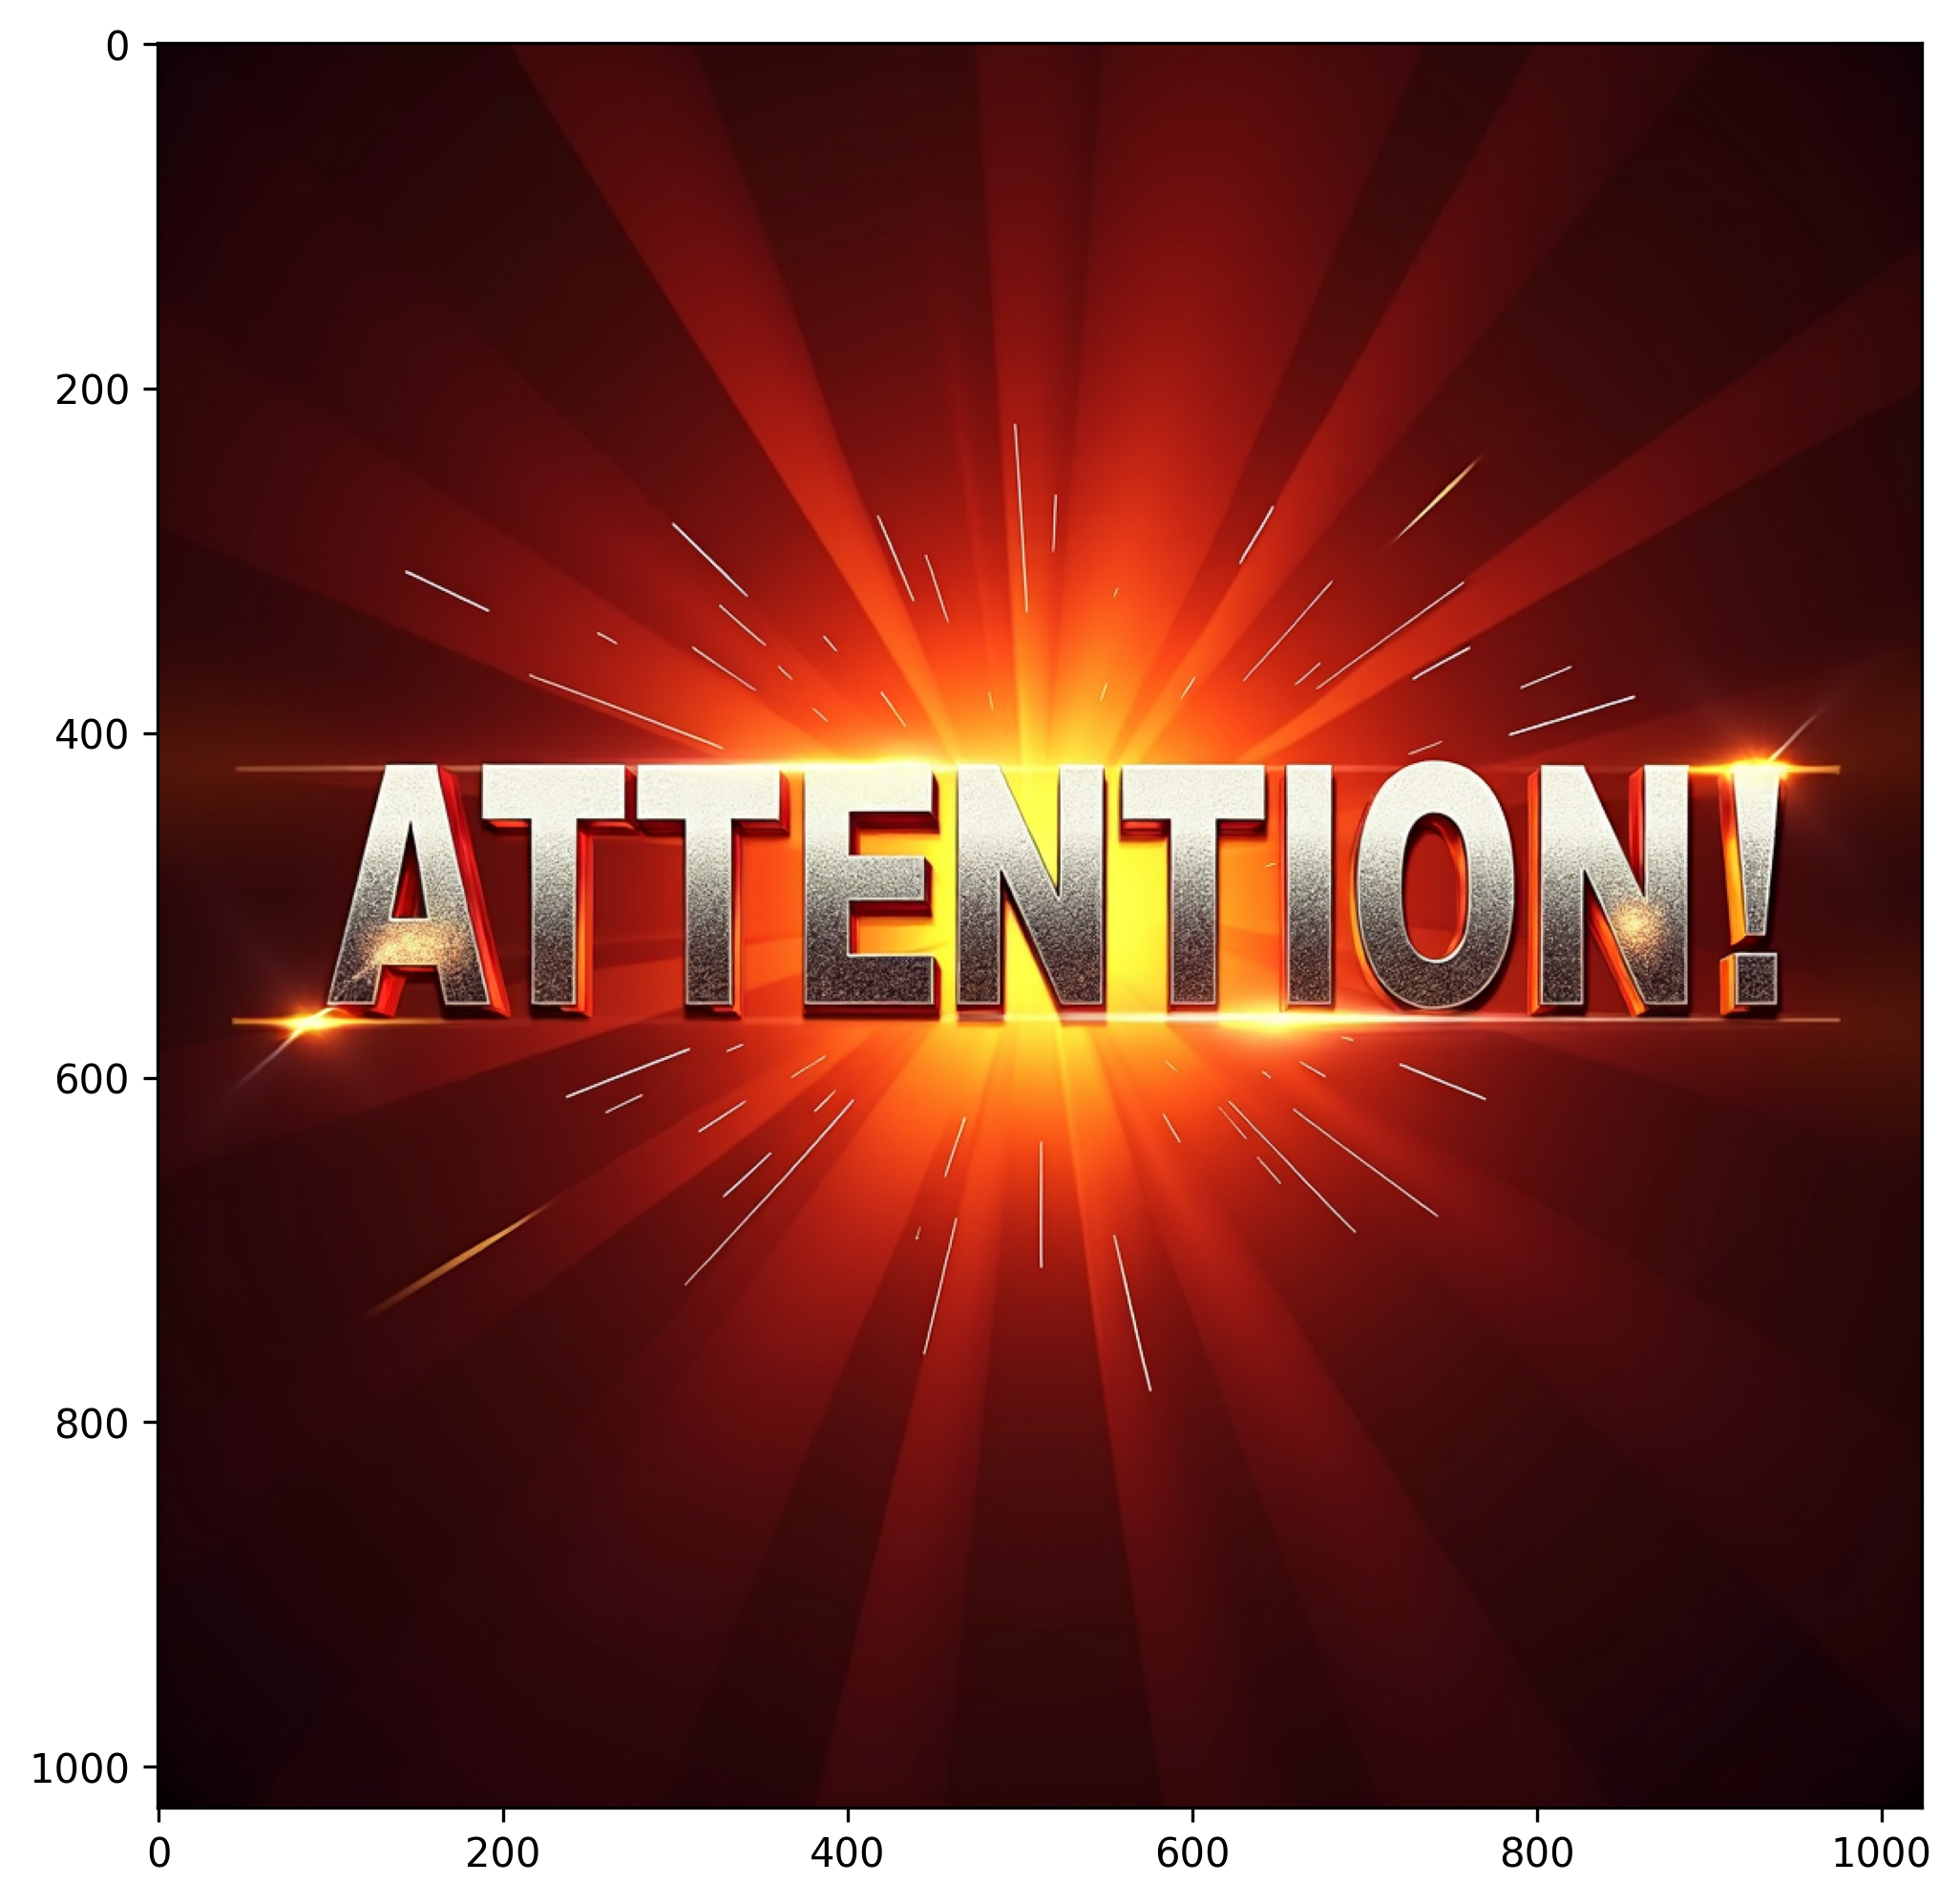

In [14]:
@torch.inference_mode()
def sample(prompt, height=1024, width=1024, guidance_scale=3.5):
	(
		prompt_embeds,         # save
		pooled_prompt_embeds,  # save
		text_ids,
	) = pipeline.encode_prompt(
		prompt=prompt,
		prompt_2=prompt,
		device=pipeline.device,
		max_sequence_length=512,
	)

	prompt_embeds = prompt_embeds.to(torch.bfloat16)
	pooled_prompt_embeds = pooled_prompt_embeds.to(torch.bfloat16)

	noise = get_noise(  # save, shape [num_samples, 16, height // 8, width // 8]
		num_samples=1,
		height=height,
		width=width,
		device="cuda",
		dtype=torch.bfloat16,
		seed=0,
	)

	latent_image_ids = FluxPipeline._prepare_latent_image_ids(
		noise.shape[0],
		noise.shape[2],
		noise.shape[3],
		noise.device,
		torch.bfloat16,
	)

	packed_latents = FluxPipeline._pack_latents(
		# [num_samples, (height // 16 * width // 16), 16 * 2 * 2]
		noise,
		batch_size=noise.shape[0],
		num_channels_latents=noise.shape[1],
		height=noise.shape[2],
		width=noise.shape[3],
	)

	timesteps = timesteps = get_schedule(  # shape: [num_inference_steps]
		num_steps=50,
		image_seq_len=(height // 16) * (width // 16),  # vae // 8 and patchify // 2
		shift=True,  # Set True for Flux-dev, False for Flux-schnell
	)

	with pipeline.progress_bar(total=50) as progress_bar:
		for t_curr, t_prev in zip(timesteps[:-1], timesteps[1:]):
			t_vec = torch.full((packed_latents.shape[0],), t_curr, dtype=packed_latents.dtype,
								device=packed_latents.device)
			guidance_vec = torch.full((packed_latents.shape[0],), guidance_scale,
										device=packed_latents.device,
										dtype=packed_latents.dtype)
			pred = transformer(
				hidden_states=packed_latents,
				timestep=t_vec,
				guidance=guidance_vec,
				pooled_projections=pooled_prompt_embeds,
				encoder_hidden_states=prompt_embeds,
				txt_ids=text_ids,
				img_ids=latent_image_ids,
				joint_attention_kwargs=None,
				return_dict=pipeline,
			)[0]
			packed_latents = packed_latents + (t_prev - t_curr) * pred
			progress_bar.update()

	assert noise.shape[2] * 8 == height and noise.shape[3] * 8 == width
	assert pipeline.vae_scale_factor == 16
	img_latents = FluxPipeline._unpack_latents(  # save, shape [num_samples, 16, height//8, width//8]
		packed_latents,
		height=height,
		width=width,
		vae_scale_factor=pipeline.vae_scale_factor,
	)

	imgs = decode_imgs(img_latents, vae, pipeline)[0]

	return imgs	

prompt = "A high-impact Telegram post with the text 'ATTENTION!': the background is a vibrant and intense gradient of red and orange, with a subtle radial burst effect emanating from the center. The word 'ATTENTION!' is placed prominently in the center in a bold, sans-serif font with a metallic finish, slightly tilted for added dynamism. Surrounding the text, there are subtle, glowing lines and digital glitch effects, creating a sense of urgency and importance. The overall style is modern and eye-catching, perfect for grabbing attention on social media."
out = sample(prompt, height=1024, width=1024, guidance_scale=3.5)
plt.figure(figsize=(8, 8), dpi=300)
plt.imshow(out)